# McDonald's Reviews - Noise Detection and Data Preparation

**Step 1**: Load raw review data, create sentiment labels, detect noise patterns, and prepare dataset for machine learning models.


## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load McDonald's Customer Reviews

In [2]:
print("="*80)
print("="*80)

DATA_PATH = "/Users/elifakdeniz/Desktop/DTA/Machine Learning/Project_Exam/McDonald_s_Reviews.csv"

df = pd.read_csv(DATA_PATH, encoding='latin-1')

print(f"\nDataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Column names: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())


Dataset shape: 33396 rows, 10 columns
Column names: ['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ', 'longitude', 'rating_count', 'review_time', 'review', 'rating']

First few rows:
   reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   
1            2  McDonald's  Fast food restaurant   
2            3  McDonald's  Fast food restaurant   
3            4  McDonald's  Fast food restaurant   
4            5  McDonald's  Fast food restaurant   

                                       store_address  latitude   longitude  \
0  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
1  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
2  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
3  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
4  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   

  rating_cou

## 3. Basic Preprocessing - Create Sentiment Labels

Converting star ratings to sentiment categories for classification.

In [4]:
print("\n" + "="*80)
print("BASIC PREPROCESSING (PRESERVING NOISE FOR ANALYSIS)")
print("="*80)

def extract_rating(rating_str):
    if pd.isna(rating_str):
        return np.nan
    return int(rating_str.split()[0])

df['rating_numeric'] = df['rating'].apply(extract_rating)

def categorize_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['rating_numeric'].apply(categorize_sentiment)

print(f"Ratings converted to numeric")
print(f"Sentiment labels created")


BASIC PREPROCESSING (PRESERVING NOISE FOR ANALYSIS)
Ratings converted to numeric
Sentiment labels created


## 4. Noise Pattern Detection

Detecting informal language patterns that are common in online reviews:
- **Typos**: Consonant clusters (e.g., "pzzza")
- **Abbreviations**: Very short informal words
- **ALL CAPS**: Emphasis or shouting
- **Repeated characters**: Emphasis (e.g., "sooo good")
- **Slang**: Informal expressions (lol, omg, etc.)


In [8]:
print("\n" + "="*80)
print("="*80)

def detect_noise_patterns(text):
    """
    Detect various types of informal language and noise in text.
    Returns a dictionary with noise counts and types.
    """
    if pd.isna(text):
        return {
            'total_noise': 0,
            'typos': 0,
            'abbreviations': 0,
            'all_caps': 0,
            'repeated_chars': 0,
            'slang': 0,
            'has_noise': False,
            'noise_types': []
        }
    
    text_lower = text.lower()
    noise_types = []
    
    typo_pattern = r'\b[bcdfghjklmnpqrstvwxyz]{3,}\b'  # 3+ consonants in a row
    typos = len(re.findall(typo_pattern, text_lower))
    if typos > 0:
        noise_types.append('typos')
    
    # 2. ABBREVIATIONS (very short words, common in informal text)
    abbrev_pattern = r'\b[a-z]{1,3}\b'  # 1-3 letter words
    valid_short = {'the', 'and', 'for', 'are', 'but', 'not', 'you', 'all', 'can', 'her', 'was', 'one', 'our', 'out', 'day', 'get', 'has', 'him', 'his', 'how', 'its', 'may', 'new', 'now', 'old', 'see', 'two', 'way', 'who', 'boy', 'did', 'let', 'put', 'say', 'she', 'too', 'use'}
    words = text_lower.split()
    abbreviations = len([w for w in words if len(w) <= 3 and w not in valid_short and w.isalpha()])
    if abbreviations > 2:  # More than 2 abbreviations
        noise_types.append('abbreviations')
    
    # 3. ALL CAPS (shouting/emphasis)
    all_caps_words = len(re.findall(r'\b[A-Z]{2,}\b', text))
    if all_caps_words > 0:
        noise_types.append('all_caps')
    
    repeated = len(re.findall(r'(.)\1{2,}', text))  # Same character 3+ times
    if repeated > 0:
        noise_types.append('repeated_chars')
    
    # 5. COMMON SLANG (informal expressions)
    slang_words = ['lol', 'omg', 'wtf', 'tbh', 'smh', 'meh', 'yuck', 'ugh', 'nope', 'yep', 'gonna', 'wanna', 'gotta']
    slang_count = sum(1 for slang in slang_words if slang in text_lower)
    if slang_count > 0:
        noise_types.append('slang')
    
    total_noise = typos + (abbreviations // 2) + all_caps_words + repeated + slang_count
    
    return {
        'total_noise': total_noise,
        'typos': typos,
        'abbreviations': abbreviations,
        'all_caps': all_caps_words,
        'repeated_chars': repeated,
        'slang': slang_count,
        'has_noise': total_noise > 0,
        'noise_types': noise_types
    }

### Apply Noise Detection to All Reviews

In [9]:
print("Analyzing noise patterns in reviews...")
noise_analysis = df['review'].apply(detect_noise_patterns)
noise_df = pd.DataFrame(noise_analysis.tolist())

# Add to main dataframe
df = pd.concat([df, noise_df], axis=1)

Analyzing noise patterns in reviews...


## 5. Noise Statistics Overview

In [10]:
print("\n" + "="*80)
print("NOISE STATISTICS")
print("="*80)

total_reviews = len(df)
noisy_reviews = df['has_noise'].sum()
clean_reviews = total_reviews - noisy_reviews

print(f"\nTotal reviews: {total_reviews:,}")
print(f"Reviews with noise: {noisy_reviews:,} ({noisy_reviews/total_reviews*100:.1f}%)")
print(f"Clean reviews: {clean_reviews:,} ({clean_reviews/total_reviews*100:.1f}%)")


NOISE STATISTICS

Total reviews: 33,396
Reviews with noise: 18,584 (55.6%)
Clean reviews: 14,812 (44.4%)


### Breakdown by Noise Type

In [11]:
print("\n" + "-"*80)
print("NOISE TYPES BREAKDOWN:")
print("-"*80)
print(f"Reviews with typos: {(df['typos'] > 0).sum():,} ({(df['typos'] > 0).sum()/total_reviews*100:.1f}%)")
print(f"Reviews with abbreviations: {(df['abbreviations'] > 2).sum():,} ({(df['abbreviations'] > 2).sum()/total_reviews*100:.1f}%)")
print(f"Reviews with ALL CAPS: {(df['all_caps'] > 0).sum():,} ({(df['all_caps'] > 0).sum()/total_reviews*100:.1f}%)")
print(f"Reviews with repeated chars: {(df['repeated_chars'] > 0).sum():,} ({(df['repeated_chars'] > 0).sum()/total_reviews*100:.1f}%)")
print(f"Reviews with slang: {(df['slang'] > 0).sum():,} ({(df['slang'] > 0).sum()/total_reviews*100:.1f}%)")


--------------------------------------------------------------------------------
NOISE TYPES BREAKDOWN:
--------------------------------------------------------------------------------
Reviews with typos: 1,830 (5.5%)
Reviews with abbreviations: 14,495 (43.4%)
Reviews with ALL CAPS: 2,188 (6.6%)
Reviews with repeated chars: 2,821 (8.4%)
Reviews with slang: 3,033 (9.1%)


## 6. Categorize Reviews by Noise Level

Creating noise categories for analysis:
- **Clean**: No noise detected
- **Low Noise**: Score 1-2
- **Medium Noise**: Score 3-5
- **High Noise**: Score 6+


In [12]:
print("\n" + "="*80)
print("CATEGORIZING REVIEWS BY NOISE LEVEL")
print("="*80)

def categorize_noise_level(noise_score):
    """Categorize reviews by noise level"""
    if noise_score == 0:
        return 'clean'
    elif noise_score <= 2:
        return 'low_noise'
    elif noise_score <= 5:
        return 'medium_noise'
    else:
        return 'high_noise'

df['noise_level'] = df['total_noise'].apply(categorize_noise_level)

noise_distribution = df['noise_level'].value_counts()
print("\nNoise Level Distribution:")
for level in ['clean', 'low_noise', 'medium_noise', 'high_noise']:
    count = noise_distribution.get(level, 0)
    pct = count / total_reviews * 100
    print(f"  {level:15s}: {count:6,} ({pct:5.1f}%)")


CATEGORIZING REVIEWS BY NOISE LEVEL

Noise Level Distribution:
  clean          : 14,812 ( 44.4%)
  low_noise      :  8,359 ( 25.0%)
  medium_noise   :  5,238 ( 15.7%)
  high_noise     :  4,987 ( 14.9%)


## 7. Examples of Reviews by Noise Level

In [13]:
print("\n" + "="*80)
print("EXAMPLES OF NOISY REVIEWS")
print("="*80)

# Get examples of each noise level
for level in ['clean', 'low_noise', 'medium_noise', 'high_noise']:
    examples = df[df['noise_level'] == level].head(3)
    print(f"\n{level.upper().replace('_', ' ')} EXAMPLES:")
    print("-" * 80)
    for idx, row in examples.iterrows():
        print(f"\nRating: {row['rating_numeric']} stars | Sentiment: {row['sentiment']}")
        print(f"Noise score: {row['total_noise']}")
        print(f"Noise types: {', '.join(row['noise_types']) if row['noise_types'] else 'None'}")
        print(f"Review: {row['review'][:200]}...")
        print("-" * 80)


EXAMPLES OF NOISY REVIEWS

CLEAN EXAMPLES:
--------------------------------------------------------------------------------

Rating: 1 stars | Sentiment: negative
Noise score: 0
Noise types: None
Review: Worst McDonaldï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...
--------------------------------------------------------------------------------

Rating: 1 stars | Sentiment: negative
Noise score: 0
Noise types: None
Review: Didnï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½t take card. But didnï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...
--------------------------------------------------------------------------------

Rating: 4 stars | Sentiment: positive
Noise score: 0
Noise types: None
Review: With all the new upgrades everything looks great and clean great staff...
--------------------------------------------------------------------------------

LOW NOISE EXAMPLES:
------------------------------------------------------------------------

## 8. Visualizations


GENERATING VISUALIZATIONS


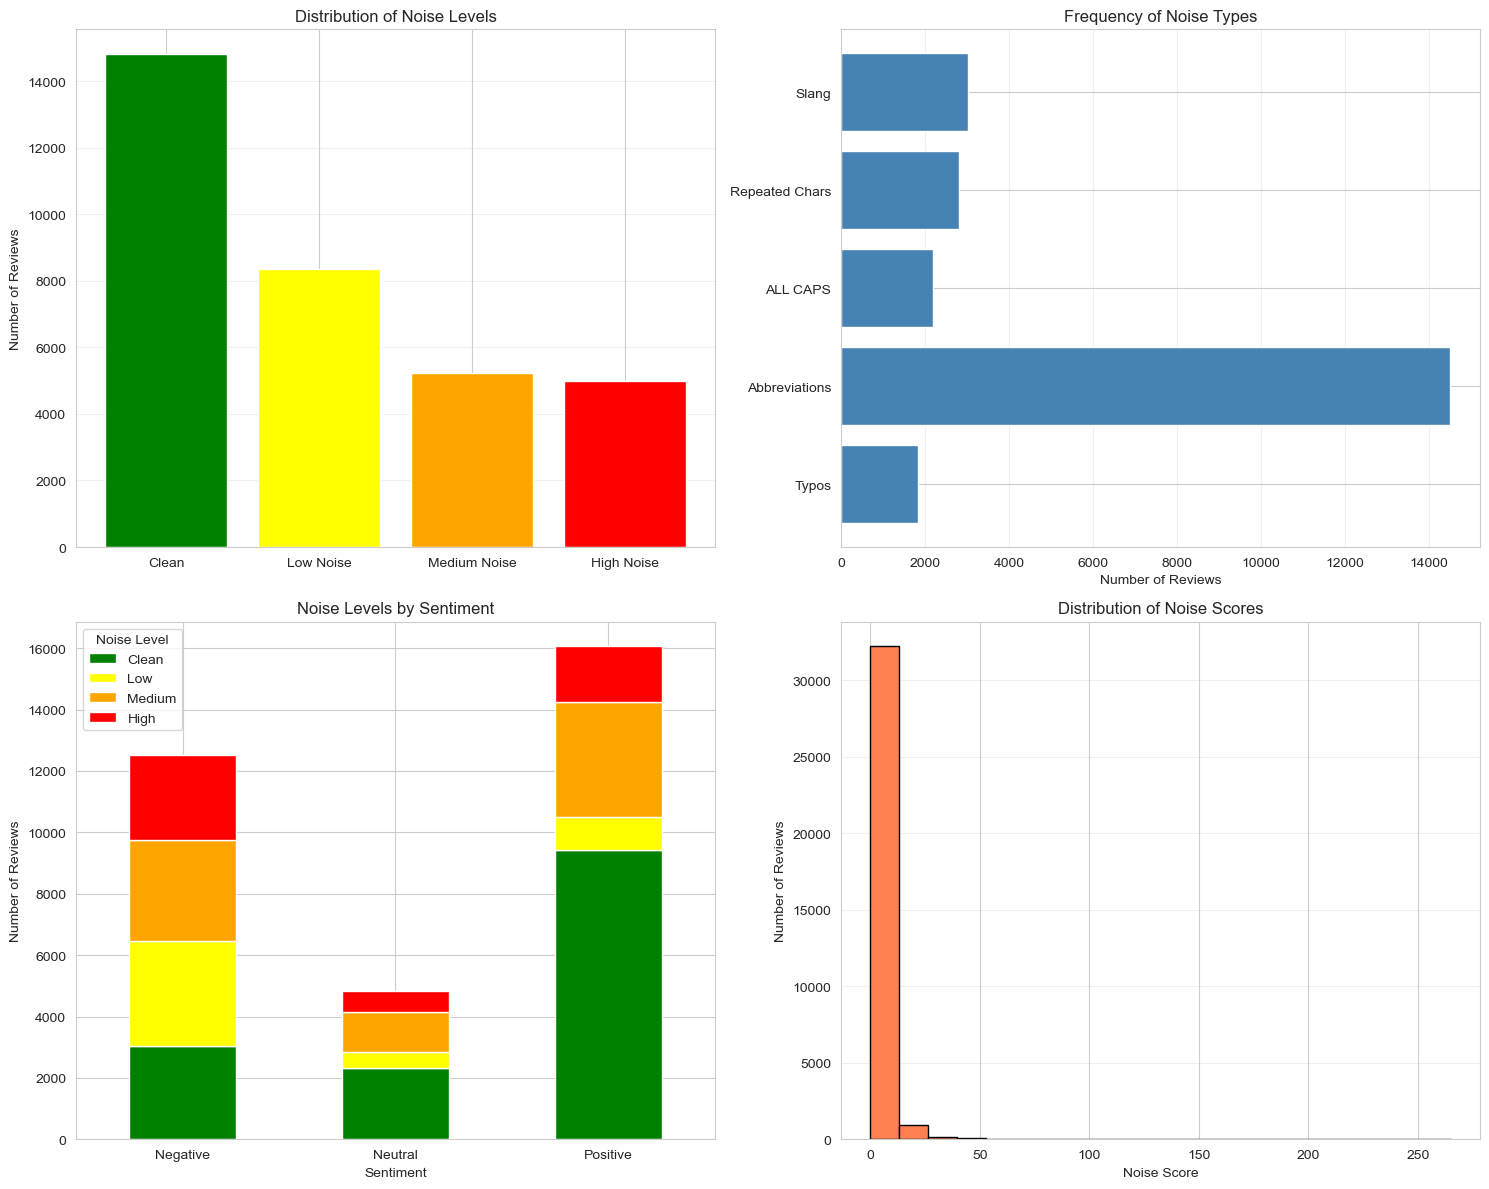

✓ Saved: noise_analysis_visualizations.png


In [14]:
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Noise level distribution
noise_counts = df['noise_level'].value_counts().reindex(['clean', 'low_noise', 'medium_noise', 'high_noise'])
axes[0, 0].bar(range(len(noise_counts)), noise_counts.values, color=['green', 'yellow', 'orange', 'red'])
axes[0, 0].set_xticks(range(len(noise_counts)))
axes[0, 0].set_xticklabels(['Clean', 'Low Noise', 'Medium Noise', 'High Noise'])
axes[0, 0].set_ylabel('Number of Reviews')
axes[0, 0].set_title('Distribution of Noise Levels')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Noise types frequency
noise_types_counts = {
    'Typos': (df['typos'] > 0).sum(),
    'Abbreviations': (df['abbreviations'] > 2).sum(),
    'ALL CAPS': (df['all_caps'] > 0).sum(),
    'Repeated Chars': (df['repeated_chars'] > 0).sum(),
    'Slang': (df['slang'] > 0).sum()
}
axes[0, 1].barh(list(noise_types_counts.keys()), list(noise_types_counts.values()), color='steelblue')
axes[0, 1].set_xlabel('Number of Reviews')
axes[0, 1].set_title('Frequency of Noise Types')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Noise by sentiment
noise_by_sentiment = df.groupby(['sentiment', 'noise_level']).size().unstack(fill_value=0)
noise_by_sentiment.plot(kind='bar', stacked=True, ax=axes[1, 0], 
                        color=['green', 'yellow', 'orange', 'red'])
axes[1, 0].set_xlabel('Sentiment')
axes[1, 0].set_ylabel('Number of Reviews')
axes[1, 0].set_title('Noise Levels by Sentiment')
axes[1, 0].legend(title='Noise Level', labels=['Clean', 'Low', 'Medium', 'High'])
axes[1, 0].set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)

# 4. Noise score distribution
axes[1, 1].hist(df['total_noise'], bins=20, color='coral', edgecolor='black')
axes[1, 1].set_xlabel('Noise Score')
axes[1, 1].set_ylabel('Number of Reviews')
axes[1, 1].set_title('Distribution of Noise Scores')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('noise_analysis_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: noise_analysis_visualizations.png")

## 9. Generate Data Overview Table

In [15]:
print("\n" + "="*80)
print("GENERATING DATA OVERVIEW TABLE")
print("="*80)

df['review_length'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().str.len()

overview_stats = {
    'Total Samples': f"{len(df):,}",
    'Reviews with Noise': f"{noisy_reviews:,} ({noisy_reviews/total_reviews*100:.1f}%)",
    'Clean Reviews': f"{clean_reviews:,} ({clean_reviews/total_reviews*100:.1f}%)",
    'Mean Review Length (words)': f"{df['word_count'].mean():.1f}",
    'Median Review Length (words)': f"{int(df['word_count'].median())}",
    'Reviews with Typos': f"{(df['typos'] > 0).sum():,} ({(df['typos'] > 0).sum()/total_reviews*100:.1f}%)",
    'Reviews with Abbreviations': f"{(df['abbreviations'] > 2).sum():,} ({(df['abbreviations'] > 2).sum()/total_reviews*100:.1f}%)",
    'Reviews with Slang': f"{(df['slang'] > 0).sum():,} ({(df['slang'] > 0).sum()/total_reviews*100:.1f}%)",
    'Negative Sentiment': f"{(df['sentiment'] == 'negative').sum():,} ({(df['sentiment'] == 'negative').sum()/len(df)*100:.1f}%)",
    'Neutral Sentiment': f"{(df['sentiment'] == 'neutral').sum():,} ({(df['sentiment'] == 'neutral').sum()/len(df)*100:.1f}%)",
    'Positive Sentiment': f"{(df['sentiment'] == 'positive').sum():,} ({(df['sentiment'] == 'positive').sum()/len(df)*100:.1f}%)"
}

overview_df = pd.DataFrame(list(overview_stats.items()), columns=['Property', 'Value'])
print("\n" + overview_df.to_string(index=False))

overview_df.to_csv('data_overview_with_noise.csv', index=False)
print("\n✓ Saved: data_overview_with_noise.csv")


GENERATING DATA OVERVIEW TABLE

                    Property          Value
               Total Samples         33,396
          Reviews with Noise 18,584 (55.6%)
               Clean Reviews 14,812 (44.4%)
  Mean Review Length (words)           22.1
Median Review Length (words)             11
          Reviews with Typos   1,830 (5.5%)
  Reviews with Abbreviations 14,495 (43.4%)
          Reviews with Slang   3,033 (9.1%)
          Negative Sentiment 12,517 (37.5%)
           Neutral Sentiment  4,818 (14.4%)
          Positive Sentiment 16,061 (48.1%)

✓ Saved: data_overview_with_noise.csv


## 10. Save Processed Dataset

In [16]:
print("\n" + "="*80)
print("SAVING PROCESSED DATA")
print("="*80)

df.to_csv('data_with_noise_analysis.csv', index=False)
print("✓ Saved: data_with_noise_analysis.csv")

print(f"\n{'='*80}")
print("STEP 1 COMPLETE!")
print(f"{'='*80}")



SAVING PROCESSED DATA
✓ Saved: data_with_noise_analysis.csv

STEP 1 COMPLETE!
